In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
name = 'N604O'

In [4]:
reg = 'N604O'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.05

In [7]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.25
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

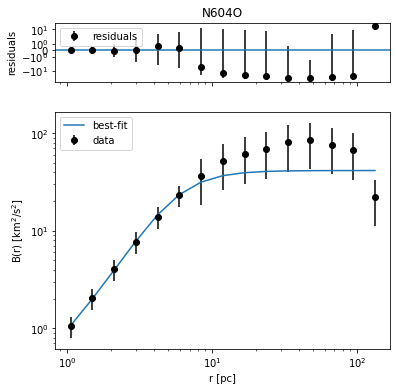

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 15
    # variables        = 5
    chi-square         = 8.05191873
    reduced chi-square = 0.80519187
    Akaike info crit   = 0.66790319
    Bayesian info crit = 4.20815420
[[Variables]]
    r0:     5.44440518 +/- 1.05053684 (19.30%) (init = 8.184591)
    sig2:   20.3929443 +/- 3.92142130 (19.23%) (init = 35.29953)
    m:      2.60016263 +/- 0.50586845 (19.46%) (init = 1.5)
    s0:     0.54318789 +/- 0.86987604 (160.14%) (init = 1.556345)
    noise:  0.75666948 +/- 1.31523279 (173.82%) (init = 2.00713)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  0.965
    C(r0, m)       = -0.720
    C(r0, sig2)    =  0.719
    C(sig2, m)     = -0.430
    C(r0, s0)      =  0.330
    C(r0, noise)   =  0.236
    C(m, noise)    =  0.194
    C(sig2, noise) = -0.129


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.016345442661892837 < 1e-05 at iteration 5 and prob(r0=2.7222025922746185) = 0.9710330118683662 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.03458398724189956 < 1e-05 at iteration 5 and prob(m=1.3000813130144628) = 0.9430592476655509 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=6.708551103342433e-09 < 1e-05 at iteration 8 and prob(s0=0.10863757714471454) = 0.2444313000208238 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.5101117193476721 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :      -inf  -1.73008  -0.87459   5.44441  +1.14980  +3.67059 +12.45878
 sig2 : -12.94179  -8.09426  -3.87134  20.39294  +4.06957  +9.07988 +16.02182
 m    :      -inf      -inf  -0.54430   2.60016  +0.55379  +1.45893  +3.97508
 s0   :      -inf      -inf      -inf   0.54319  +0.34705  +0.94189  +2.14838
 noise:      -inf      -inf      -inf   0.75667  +0.43453  +0.78295  +1.19995


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 21.66101598739624 seconds ---
